# Bathymetric data

[*GEBCO Compilation Group (2020) GEBCO 2020 Grid (doi:10.5285/a29c5465-b138-234d-e053-6c86abc040b9*)](https://www.gebco.net/data_and_products/gridded_bathymetry_data/)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray

ds = xarray.open_dataset("../tests/testdata/gebco_2020_n56.3_s55.2_w12.2_e13.1.nc")
ds

<xarray.Dataset>
Dimensions:    (lat: 264, lon: 216)
Coordinates:
  * lat        (lat) float64 55.2 55.21 55.21 55.21 ... 56.29 56.29 56.29 56.3
  * lon        (lon) float64 12.2 12.21 12.21 12.21 ... 13.09 13.09 13.09 13.1
Data variables:
    elevation  (lat, lon) int16 ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2020 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2020 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/a29c5465-b138-234d-e053-6c86abc040b9
    comment:      The data in the GEBCO_2020 Grid should not be used for navi...
    node_offset:  1.0

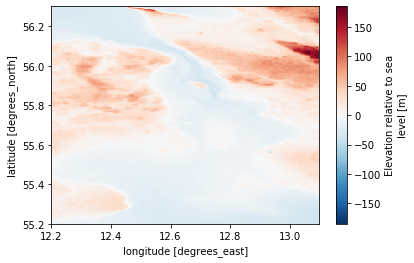

In [2]:
ds.elevation.plot()

In [3]:
ds.elevation.sel(lon=12.74792, lat=55.865, method="nearest")

<xarray.DataArray 'elevation' ()>
array(-43, dtype=int16)
Coordinates:
    lat      float64 55.86
    lon      float64 12.75
Attributes:
    standard_name:       height_above_reference_ellipsoid
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [4]:
el = ds.elevation.values
el = np.flipud(el)
el.shape

(264, 216)

Dfs2 need a time dimension even if it only has a single timestep.

In [5]:
el = np.expand_dims(el,axis=0)


Set land values to missing values

In [6]:
el = el.astype('float32')
el[el > 0.0] = np.nan

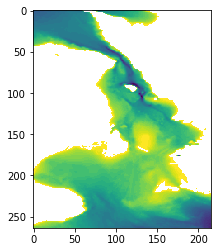

In [7]:
import matplotlib.pyplot as plt
plt.imshow(el[0])

# Coordinates

In [8]:
lat = ds.lat.values
lon = ds.lon.values


nx = len(lon)
ny = len(lat)

dx = (lon[-1] - lon[0]) / (nx-1)
dy = (lat[-1] - lat[0]) / (ny-1)

x0 = lon[0]
y0 = lat[0]


x0, y0, nx, ny, dx, dy

(12.20208333333332,
 55.20208333333332,
 216,
 264,
 0.004166666666666711,
 0.00416666666666666)

# Create dfs2


In [9]:
from mikeio.eum import EUMType, EUMUnit

from mikeio import Dfs2
from mikeio.eum import ItemInfo

d = []
d.append(el)

dfsfilename = "gebco_sound.dfs2"

coordinate = ['LONG/LAT', x0, y0, 0]

dfs = Dfs2()
dfs.create(filename=dfsfilename,
           data=d,
           coordinate=coordinate, length_x=dx, length_y=dy,
           items=[ItemInfo("Elevation", EUMType.Total_Water_Depth)]
)

# Read Dfs2

In [10]:
from mikeio import Dfs2
dfs = Dfs2()
newds = dfs.read("gebco_sound.dfs2")

In [11]:
newds.items

[Elevation <Total Water Depth> (meter)]

Find index of the deepest point (55.865N, 12.74792E)

In [12]:
k,j = dfs.find_closest_element_index(lon=12.74792,lat=55.865)
print(k,j)

104 131


In [13]:
newds.data[0][0,k,j]

-43.0

## Export to netcdf

In [14]:
xds2 = newds.to_xarray()

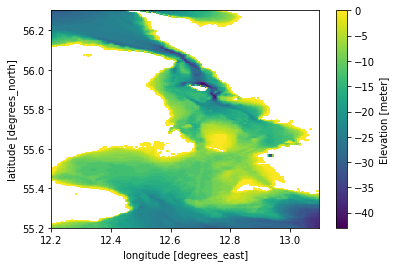

In [15]:
xds2.Elevation.plot()

In [16]:
xds2

<xarray.Dataset>
Dimensions:    (lat: 264, lon: 216)
Coordinates:
  * lon        (lon) float64 12.2 12.21 12.21 12.21 ... 13.09 13.09 13.09 13.1
  * lat        (lat) float64 56.3 56.29 56.29 56.29 ... 55.21 55.21 55.21 55.2
Data variables:
    Elevation  (lat, lon) float64 -31.0 -30.0 -31.0 -31.0 ... -37.0 -38.0 -38.0

In [17]:
xds2.to_netcdf("test_dfs2.nc")

# Clean up

In [18]:
import os
os.remove(dfsfilename)
os.remove("test_dfs2.nc")